# Colab commands

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/build_model/TrainValidate.py /content
!cp /content/drive/MyDrive/Colab\ Notebooks/datasets/final_features_removed.csv /content
!cp /content/drive/MyDrive/Colab\ Notebooks/datasets/final_labels_removed.csv /content
!cp /content/drive/MyDrive/Colab\ Notebooks/datasets/final_sources_removed.csv /content
!cp /content/drive/MyDrive/all_removed_weighted_sampler_full_epoch_1000_fold_2.pth /content
!cp /content/drive/MyDrive/Colab\ Notebooks/datasets/final_features_prices.csv /content
!mkdir /content/models

In [ ]:
!pip install --quiet torchinfo
!pip install --quiet torch_snippets

# Import packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter

import torchinfo
from torch_snippets import Report
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from TrainValidate import TrainValidate, create_weighted_sampler

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.has_mps:
    device = "mps"

/Users/luowx0905/opt/anaconda3/envs/ML_m1/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device

'mps'

# Class for collecting data

In [3]:
class StatusDataset(Dataset):
    def __init__(self, features, labels):
        assert len(features) == len(labels)
        self.features = features
        self.labels = labels

    def __getitem__(self, item):
        features = self.features.to_numpy()[item]
        features = torch.tensor(features).float().to(device)

        labels = self.labels.to_numpy()[item]
        status = torch.tensor([labels[0]]).float().to(device)

        return features, status

    def __len__(self):
        return len(self.features)

# Build the model

In [4]:
class PredictStatus(nn.Module):
    def __init__(self, in_features):
        super(PredictStatus, self).__init__()

        self.hidden = nn.Sequential(nn.Linear(in_features, 256),
                                    nn.BatchNorm1d(256),
                                    nn.Dropout(0.7),
                                    nn.ReLU(),
                                    nn.Linear(256, 512),
                                    nn.BatchNorm1d(512),
                                    nn.Dropout(0.7),
                                    nn.ReLU(),
                                    nn.Linear(512, 1024),
                                    nn.BatchNorm1d(1024),
                                    nn.Dropout(0.8),
                                    nn.ReLU(),
                                    nn.Linear(1024, 256),
                                    nn.BatchNorm1d(256),
                                    nn.Dropout(0.7),
                                    nn.ReLU(),
                                    nn.Linear(256, 64),
                                    nn.BatchNorm1d(64),
                                    nn.Dropout(0.8),
                                    nn.ReLU())
        self.status = nn.Sequential(nn.Linear(64, 1),
                                    nn.Sigmoid())

    def forward(self, x):
        hidden = self.hidden(x)
        out = self.status(hidden)

        return out

# Prepare data

In [73]:
features = pd.read_csv("../datasets/final_features_prices.csv")
labels = pd.read_csv("../datasets/final_labels_removed.csv")

# remove feature
features = features.loc[:, features.columns != "DESC Council Tax Band"]

scaler = StandardScaler()
scaler.fit(features)
features[:] = scaler.transform(features)

x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state=1, test_size=0.1)

# Train the model

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
epochs = 300

for fold, (train_id, val_id) in enumerate(kfold.split(x_train.index)):
    train_feature, train_label = x_train.iloc[train_id], y_train.iloc[train_id]
    val_feature, val_label = x_train.iloc[val_id], y_train.iloc[val_id]
    print("\n\n-------------This is fold {}----------------".format(fold))

    train_data = StatusDataset(train_feature, train_label)
    val_data = StatusDataset(val_feature, val_label)
    in_features = len(train_data[0][0])

    train_sampler = create_weighted_sampler(train_label["Completed"].values, [0.1, 0.0])
    val_sampler = create_weighted_sampler(val_label["Completed"].values, [0.1, 0.0])

    train_loader = DataLoader(train_data, batch_size=32, shuffle=False, drop_last=True, sampler=train_sampler)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False, drop_last=True, sampler=val_sampler)

    model = PredictStatus(in_features).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    train_validate = TrainValidate(model, nn.BCELoss(), optimizer)
    train_validate.set_loader(train_loader, val_loader)
    train_validate.train(epochs)

    train_validate.save_model("models/status_ablation_postcode_fold_{}.pth".format(fold))



-------------This is fold 0----------------


# Testing

In [99]:
filename = "models/status_ablation_council_fold_2.pth"

model = torch.load(filename, map_location=torch.device("cpu"))
model.eval()
completed, out_labels = [], []
test_data = StatusDataset(x_test, y_test)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, drop_last=False)

for data in test_loader:
    x, y = data
    x = x.to("cpu")
    y = y.to("cpu")

    pred_com = model(x)
    pred_com = torch.where(pred_com > 0.5, 1.0, 0.0)
    for item in pred_com.tolist():
        completed.append(item[0])
    for item in y.tolist():
        out_labels.append(item[0])

pred = pd.DataFrame({"pred_completed": completed, "Truth": out_labels})
pred

,pred_completed,Truth
0,0.0,0.0
1,0.0,1.0
2,1.0,1.0
3,0.0,1.0
4,1.0,1.0
...,...,...
895,1.0,1.0
896,0.0,0.0
897,1.0,0.0
898,1.0,1.0


[Text(0, 0.5, 'Completed'), Text(0, 1.5, 'Not Completed')]

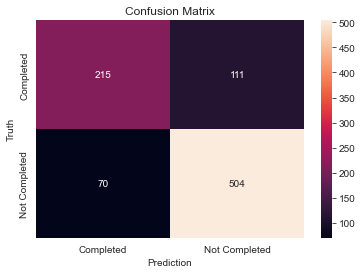

In [100]:
cm = confusion_matrix(pred["pred_completed"], pred["Truth"])
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel("Prediction")
plt.ylabel("Truth")
plt.title("Confusion Matrix")
ax.xaxis.set_ticklabels(['Completed', 'Not Completed'])
ax.yaxis.set_ticklabels(['Completed', 'Not Completed'])

In [101]:
print("Accuracy: {}".format(accuracy_score(pred["pred_completed"], pred["Truth"])))
print("Recall: {}".format(recall_score(pred["pred_completed"], pred["Truth"])))
print("Precision: {}".format(precision_score(pred["pred_completed"], pred["Truth"])))
print("F1 Score: {}".format(f1_score(pred["pred_completed"], pred["Truth"])))

Accuracy: 0.7988888888888889
Recall: 0.8780487804878049
Precision: 0.8195121951219512
F1 Score: 0.847771236333053
